In [1]:
%reload_ext autoreload
%autoreload 2

from qwanta import Tuner, QuantumNetwork, Configuration, Xperiment
from qwanta import QuantumNetwork, Configuration, Xperiment, Tuner
import pandas as pd
import ast
import numpy as np
import networkx as nx
from qwanta.Qubit import PhysicalQubit
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from GeneticFunc import *
from tqdm import tqdm

3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]


In [95]:
weight1 = 0.5
weight2 = 0.5
mutationRate = 0.05
numPopulation = 10

def create_population(population_size=numPopulation, num_parameter=4):
    # create individual in population
    population = []
    for i in range(population_size):
        individual = [random.random() for i in range(num_parameter)]
        population.append(individual)
    
    return population
    
def Heaviside(x):
    if x >= 0:
        return 1
    else:
        return 0
    
# This calculate cost for one individual
def singleObject_cost(baseParameter, simParameter, w1, w2, objectFidelity, simFidelity):
    # cost function
    output = []
    for i in range(len(baseParameter)):
        k = log(simParameter[i])/log(baseParameter[i])
        output.append(k)

    cost = sum(output)

    cost_single_objective = w1*Heaviside(simFidelity - objectFidelity) + w2*cost

    return cost_single_objective

# hope this will calculate cost for all individual in population
# def costCalculations(population, baseParameter, w1, w2, objectFidelity, simFidelity):

#     cost = []
#     for ind in population:
#         cost_ind = singleObject_cost(baseParameter, ind, w1, w2, objectFidelity, simFidelity)
#         cost.append(cost_ind)
#     return cost


# def cost_calculations(population, baseParameter ,w1, w2, minFidelity, simulateFidelity):
#     # cost function
#     output = []
#     cost_population = []
#     for ind in population:
#         for i in range(len(baseParameter)):
#             k = log(ind[i])/log(baseParameter[i])
#             output.append(k)

#         cost = sum(output)
#         # cost in one individual
#         cost_single_objective = w1*Heaviside(minFidelity - simulateFidelity) + w2*cost

#         cost_population.append(cost_single_objective)

#     return cost_population

def visualize(result):
    to_print = ['fidelity', 'simulation_time', 'Resources Produced', 'Base Resources Attempt', 'Resource Used in Fidelity Estimation', 'Time used', 'Fidelity Estimation Time']
    for key in to_print:
        print(f'{key}: {result[key]}')

def normalize_list(l):
    return [i/sum(l) for i in l]

def roulette_wheel_selection(population, costs):
    """
        Performs roulette wheel selection on a population based on their fitnesses.
        Args:
            population (list): List of individuals.
            fitnesses (list): List of corresponding fitness values for the individuals.
            num_selected (int): Number of individuals to select.
        Returns:
            selected (list): List of selected individuals.
    """

    max_cost = 1
    fitnesses = [max_cost +1 -cost for cost in costs]
    probabilities = normalize_list(fitnesses)

    # checked that sum(probabilities) = 1
    if sum(probabilities) < 0.999:
        print(f'Sum Probability: {sum(probabilities)}')
        raise ValueError('Probabilities must sum to 1.')
    elif sum(probabilities) > 1.001:
        print(f'Sum Probability: {sum(probabilities)}')
        raise ValueError('Probabilities must not over 1.')
        
    selected = []
    # parent size = 5
    while len(selected) < 5:

        index = np.random.multinomial(1, probabilities).argmax()
        chosen_parent = population[index]

        selected.append(chosen_parent)

        del population[index]
        del probabilities[index]
        
    return selected

def crossover(parents, cross=0.8):
    offspring = []
    numParent = len(parents)

    num_cross = int(cross*len(parents))
    num_pick = len(parents) - num_cross

    for i in range(num_cross):
        #select two parents
        pool = parents
        parent1 = random.choice(pool)
        parent2 = random.choice(pool)
        #select random point to crossover
        crossover_point = random.randint(0, len(parent1)-1)
            
        #create child
        child = parent1[:crossover_point] + parent2[crossover_point:]
        offspring.append(child)
        # print(f'child offspring {offspring}')

    for i in range(num_pick):
        picked_ind = random.choice(parents)
        offspring.append(picked_ind)
        del parents[parents.index(picked_ind)]
        

    if num_cross+num_pick != numParent:
        print(f'Num cross: {num_cross}, Num pick: {num_pick}, Num parents: {numParent}')
        raise ValueError('Number is not match in crossover function parent')
    elif num_cross+num_pick != len(offspring):
        print(f'Num cross: {num_cross}, Num pick: {num_pick}, Num offspring: {len(offspring)}')
        raise ValueError('Number is not match in crossover function offspring')

    return offspring

def mutate(children):
    for i in range(len(children)):
        
        if random.random() < mutationRate:
            children[i][random.randint(0, len(children[0])-1)] = random.random()
    return children

def parameterTransform(loss, coherenceTime, gateErr, meaErr):
    '''
    This function change the [0-1] value into real simulation value

    # value from Bsc_Thesis
    meaErr: 0.01, 0.03, 0.05
    memoryTime: 0.25, 0.5, 1 second
    gate error 0.01, 0.03
    loss: 0.001, 0.003, 0.005, 0.007 dB/km

    # plan to normalize value in interval of previous research
    meaErr: 0 - 0.10
    memoryTime: 0 - 1
    gateError: 0 - 0.05
    loss 0.001 - 0.010

    '''
    # loss = loss[0]
    # coherenceTime = coherenceTime[0]
    # gateErr = gateErr[0]
    # meaErr = meaErr[0]

    lossSim = 0.010 - loss*0.010 # loss sim interval [0, 0.01], 0-> 0.01, 1->0
    coherenceTimeSim = coherenceTime
    gateErrSim = 0.03 - gateErr*0.03
    meaErrSim = 0.1 - meaErr*0.1
    return lossSim, coherenceTimeSim, gateErrSim, meaErrSim

/var/folders/b7/kcj1zfy15d35hgd16vscfs0r0000gn/T/ipykernel_24502/2612061800.py:2: RuntimeWarning: divide by zero encountered in log
  y = 1/(np.log(x)/np.log(base))
/var/folders/b7/kcj1zfy15d35hgd16vscfs0r0000gn/T/ipykernel_24502/2612061800.py:2: RuntimeWarning: divide by zero encountered in divide
  y = 1/(np.log(x)/np.log(base))


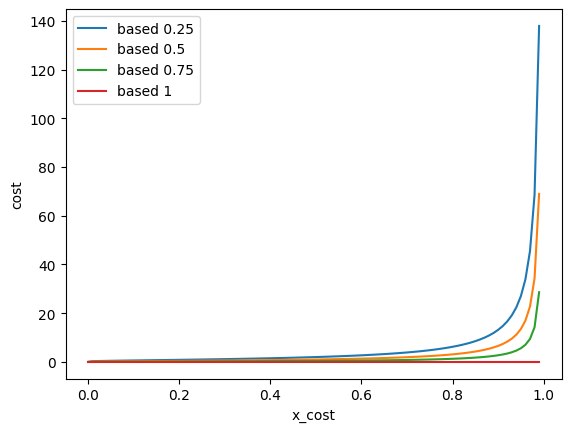

In [63]:
def cost_plot(x, base):
    y = 1/(np.log(x)/np.log(base))
    return y

plt.xlabel('x_cost') # a set of parameter that mapped to a cost
plt.ylabel('cost')

for base in [0.25, 0.5, 0.75, 1]:
    plt.plot(np.arange(0, 1, 0.01), cost_plot(np.arange(0, 1, 0.01), base), label=f'based {base}')    

plt.legend()

In [10]:
baseline_value = [np.random.random() for i in range(4)]
population = create_population()

In [18]:
lossPhoton, coherenceTime, gateErr, meaErr = parameter_feed(population_index=0, exper=exper)
print(lossPhoton, coherenceTime, gateErr, meaErr)

lossPhoton, coherenceTime, gateErr, meaErr = parameterTransform(lossPhoton, coherenceTime, gateErr, meaErr)
print(lossPhoton, coherenceTime, gateErr, meaErr)

3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
[0.9045446659119933] [0.8923113789720973] [0.6040153157627453] [0.373563269493811]
0.0009545533408800658 0.8923113789720973 0.011879540527117642 0.06264367305061891


### Define configuration and read the network timeline

As of current implementation, the timeline should be format as in csv or excel file to let Xperiment to be able to read it.
However, Xperiment is just a class wrapping that does the validation of the timeline and the network, so you can use any other format as long as you can read it and pass it to the Xperiment class.

In [35]:
# Hyperparameters
loss = lossPhoton
depo_prob = 0.03
gate_error = gateErr
measurement_error = meaErr
memory_time = coherenceTime

num_hops = 2
num_nodes = num_hops + 1

node_info = {f'Node {i}': {'coordinate': (int(i*100), 0, 0)} for i in range(num_nodes)}
edge_info = {
    (f'Node {i}', f'Node {i+1}'): {
    'connection-type': 'Space',
    'depolarlizing error': [1 - depo_prob, depo_prob/3, depo_prob/3, depo_prob/3],
    'loss': loss,
    'light speed': 300000,
    'Pulse rate': 0.0001,
    f'Node {i}':{
        'gate error': gate_error,
        'measurement error': measurement_error,
        'memory function': memory_time
    },
    f'Node {i+1}':{
        'gate error': gate_error,
        'measurement error': measurement_error,
        'memory function': memory_time
    },
    }
for i in range(num_hops)}

exps = Xperiment(
    timelines_path = 'network/exper_id3_selectedStats_2hops.xlsx',
    nodes_info_exp = node_info,
    edges_info_exp = edge_info,
    gate_error = gate_error,
    measurement_error = measurement_error,
    memory_time = memory_time,
    strategies_list=['0G']
)

NameError: name 'lossPhoton' is not defined

### Calculate fidelity of all 1st generation individual

In [97]:
# loop every generation
# for generation in range(exper.GENERATIONS):
result_list = []
fidelity_per_generation = [] # collect fidelity of current generation
fidelity_history = []
cost_history = []
cost_value = []
population = create_population()
numGeneration = 100

for g in tqdm(range(numGeneration)):
    # loop every individual in population
    for ind in population:

        loss = ind[0]
        gate_error = ind[1]
        measurement_error = ind[2]
        memory_time = ind[3]
        depo_prob = 0.03

        loss, gate_error, measurement_error, memory_time = parameterTransform(loss, gate_error, measurement_error, memory_time)

        num_hops = 2
        num_nodes = num_hops + 1

        node_info = {f'Node {i}': {'coordinate': (int(i*100), 0, 0)} for i in range(num_nodes)}
        edge_info = {
            (f'Node {i}', f'Node {i+1}'): {
            'connection-type': 'Space',
            'depolarlizing error': [1 - depo_prob, depo_prob/3, depo_prob/3, depo_prob/3],
            'loss': loss,
            'light speed': 300000,
            'Pulse rate': 0.0001,
            f'Node {i}':{
                'gate error': gate_error,
                'measurement error': measurement_error,
                'memory function': memory_time
            },
            f'Node {i+1}':{
                'gate error': gate_error,
                'measurement error': measurement_error,
                'memory function': memory_time
            },
            }
        for i in range(num_hops)}

        exps = Xperiment(
            timelines_path = 'network/exper_id3_selectedStats_2hops.xlsx',
            nodes_info_exp = node_info,
            edges_info_exp = edge_info,
            gate_error = gate_error,
            measurement_error = measurement_error,
            memory_time = memory_time,
            strategies_list=['0G']
        )

        # run experiment
        result = exps.execute()

        # fidelity
        fidelity = result['0G']['fidelity']
        fidelity_per_generation.append(fidelity)
        
        # cost
        cost = (singleObject_cost(
            baseParameter=baseline_value,
            simParameter=ind,
            w1=weight1,
            w2=weight2,
            objectFidelity=0.8,
            simFidelity=fidelity
        ))
        cost_value.append(cost)
        
    fidelity_history.append(fidelity_per_generation)
    cost_history.append(cost_value)

    print(f'Cost value: {cost_value}')
    print(f'fidelity value: {fidelity_per_generation}')
        
    parents = roulette_wheel_selection(population=population, costs=cost_value)
    print(f'parents: {parents}')
    crossover_sim = crossover(parents=parents)
    print(f'crossover: {crossover_sim}')
    offspring = mutate(children=crossover_sim)
    print(f'offspring: {offspring}')

    # clear dummy list
    cost_value = []
    fidelity_per_generation = []

    population = offspring # 2nd generation
    print(f'generation {g+1} finished')

  1%|          | 1/100 [00:45<1:15:39, 45.85s/it]

Cost value: [8.411755281589489, 15.623822037880243, 8.055474043845328, 5.274988927088504, 9.760543630273252, 3.952247907508169, 10.516067592126012, 9.756912701145215, 6.167385216359451, 9.140571273456851]
fidelity value: [0.2781666666666666, 0.25116666666666665, 0.2606666666666667, 0.319, 0.2765, 0.42483333333333334, 0.6601666666666667, 0.6425000000000001, 0.41566666666666663, 0.25683333333333336]
parents: [[0.3397907056949432, 0.7112422057529452, 0.28758343544618636, 0.8740770810581024], [0.5631322345433302, 0.6191969811253972, 0.5271716967980695, 0.6550388677449063], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.7659090976130005, 0.12021662580153336, 0.47556455471003767, 0.4776948956610393], [0.5618539384677416, 0.7171861485638941, 0.21832435510878745, 0.79870217196503]]
crossover: [[0.5631322345433302, 0.6191969811253972, 0.5271716967980695, 0.04962331988893065], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.0496233198889306

  2%|▏         | 2/100 [01:08<53:01, 32.47s/it]  

Cost value: [6.957037696027151, 9.140571273456851, 5.274988927088504, 10.00074751275422, 11.802786796422222]
fidelity value: [0.31616666666666665, 0.24999999999999997, 0.324, 0.2816666666666667, 0.4191666666666667]
parents: [[0.3397907056949432, 0.7171861485638941, 0.21832435510878745, 0.79870217196503], [0.5618539384677416, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.6191969811253972, 0.5271716967980695, 0.6550388677449063], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.6191969811253972, 0.5271716967980695, 0.04962331988893065]]
crossover: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5618539384677416, 0.30018380936266853, 0.21832435510878745, 0.04962331988893065], [0.3397907056949432, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.6191969811253972, 0.5271716967980695, 0.04962331988893065], [0.62854517093195

  3%|▎         | 3/100 [01:31<45:06, 27.90s/it]

Cost value: [11.801701364917289, 13.614102703069642, 9.43434854370088, 6.957037696027151, 9.140571273456851]
fidelity value: [0.4403333333333333, 0.47600000000000003, 0.24999999999999997, 0.31716666666666665, 0.25]
parents: [[0.3397907056949432, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5618539384677416, 0.30018380936266853, 0.21832435510878745, 0.04962331988893065], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.6191969811253972, 0.5271716967980695, 0.04962331988893065]]
crossover: [[0.5631322345433302, 0.30018380936266853, 0.5271716967980695, 0.04962331988893065], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.3397907056949432, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.56313223

  4%|▍         | 4/100 [01:53<41:07, 25.71s/it]

Cost value: [8.654791187212213, 9.140571273456851, 11.801701364917289, 9.43434854370088, 11.801701364917289]
fidelity value: [0.47250000000000003, 0.2558333333333333, 0.45233333333333337, 0.24016666666666667, 0.43683333333333335]
parents: [[0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.3397907056949432, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.5271716967980695, 0.04962331988893065]]
crossover: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.5271716967980695, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.3397907056949432, 0.9359566969659957, 0.29819030786925915, 0.79870217196503], [0.628

  5%|▌         | 5/100 [02:16<39:00, 24.64s/it]

Cost value: [11.801701364917289, 6.843475280564792, 11.801701364917289, 7.623032637053459, 9.140571273456851]
fidelity value: [0.45149999999999996, 0.44933333333333336, 0.4435, 0.2555, 0.2485]
parents: [[0.3397907056949432, 0.9359566969659957, 0.29819030786925915, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.5271716967980695, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503]]
crossover: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.6285451709319535, 0.9359566969659957, 0.29

  6%|▌         | 6/100 [02:38<37:21, 23.85s/it]

Cost value: [11.801701364917289, 11.801701364917289, 11.801701364917289, 9.140571273456851, 9.140571273456851]
fidelity value: [0.43033333333333335, 0.44816666666666666, 0.4445, 0.25, 0.24066666666666667]
parents: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503]]
crossover: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.04962331988893065], [0.6285451709319535, 0.93595

  7%|▋         | 7/100 [03:01<36:08, 23.32s/it]

Cost value: [11.801701364917289, 11.801701364917289, 11.801701364917289, 13.61301727156471, 9.140571273456851]
fidelity value: [0.45766666666666667, 0.4261666666666667, 0.4466666666666667, 0.45899999999999996, 0.24283333333333335]
parents: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.6285451709319535, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.04962331988893065]]
crossover: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.04962331988893065], [0.5631322345433302, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503],

  8%|▊         | 8/100 [03:23<35:09, 22.93s/it]

Cost value: [11.801701364917289, 13.61301727156471, 9.193059229714978, 11.801701364917289, 11.801701364917289]
fidelity value: [0.43449999999999994, 0.4716666666666667, 0.2586666666666667, 0.43683333333333335, 0.4433333333333333]
parents: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.9359566969659957, 0.29819030786925915, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.04962331988893065]]
crossover: [[0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.04962331988893065], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0.5631322345433302, 0.30018380936266853, 0.21832435510878745, 0.79870217196503], [0

  8%|▊         | 8/100 [03:33<41:00, 26.74s/it]


KeyboardInterrupt: 

In [19]:
cross = [
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076]]

offs = [
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.5049276608067071], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076]
]

parent = [
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076], 
    [0.06047600824762789, 0.7205900172201741, 0.4839376279802563, 0.6345927363247076]
]

crossover(parent)

TypeError: 'list' object is not callable

In [22]:
fidelity_per_generation

[0.28200000000000003,
 0.26983333333333337,
 0.2828333333333333,
 0.2996666666666667,
 0.293,
 0.2818333333333333,
 0.2885,
 0.27499999999999997,
 0.2833333333333333,
 0.2833333333333333]

In [6]:
for i in result_list:
    # visualize(i['0G'])
    # print('- - - - - - - - - - - - - - - - - - - - - -')
    result_ind = i['0G']['fidelity']
    print(f'Individual Fidelity: {result_ind}')
    

Individual Fidelity: 0.7493333333333334
Individual Fidelity: 0.6986666666666668
Individual Fidelity: 0.7438333333333333
Individual Fidelity: 0.25216666666666665
Individual Fidelity: 0.7290000000000001
Individual Fidelity: 0.6098333333333333
Individual Fidelity: 0.7701666666666667
Individual Fidelity: 0.6173333333333333
Individual Fidelity: 0.8541666666666666
Individual Fidelity: 0.6891666666666666


### To validate the experiment configuration, and network topology

You can validate the experiment configuration and network topology by running the following command. 
If vis is set to True, the network topology will be visualized using pyvis library, you could see the network topology in the browser using the generated html file.
If get_table is set to True, the network topology will be printed in table format show the summary of validation.
If show_message is set to True, the validation message will be printed.

In [10]:
exps.validate(get_table=True, vis=False)

,Experiment,Resource-reachable,loss,depolarizing error,gate error,memory error,measurement error,Network
0,0G,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED
1,1G-Ss-Dp,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED
2,2G-NonLocalCNOT,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED
3,1-2G-DirectedEncoded,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED
4,HG-END2ENDPurifiedEncoded,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED
5,1-2G-DirectedEncoded-Perfect,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED
6,2G-NonLocalCNOT-Perfect,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED,PASSED


### To run the experiment
You could run the experiment by running the following command.
Set save_result to True to save the experiment result to the experiment result folder.

In [28]:
results = exps.execute()

In [29]:
results

{'0G': {'numPhysicalBuffer': 20,
  'numInternalEncodingBuffer': 20,
  'numInternalDetectingBuffer': 10,
  'numInternalInterfaceBuffer': 2,
  'memory_function': <function qwanta.qwanta.Xperiment.__init__.<locals>.memory_error_function(time, tau=0.8923113789720973)>,
  'gate_error': 0.011879540527117642,
  'measurement_error': 0.06264367305061891,
  'timeline': [{'Main Process': 'Generate physical Bell pair',
    'Edges': ['Node 0', 'Node 1'],
    'Num Trials': True,
    'Label in': 'Physical Qubit',
    'Label out': 'Physical',
    'Resource Type': nan,
    'Protocol': nan,
    'Note': nan,
    'isSuccess': 0},
   {'Main Process': 'Generate physical Bell pair',
    'Edges': ['Node 1', 'Node 2'],
    'Num Trials': True,
    'Label in': 'Physical Qubit',
    'Label out': 'Physical',
    'Resource Type': nan,
    'Protocol': nan,
    'Note': nan,
    'isSuccess': 0},
   {'Main Process': 'Entanglement swapping',
    'Edges': ['Node 0', 'Node 1', 'Node 2'],
    'Num Trials': True,
    'Label

### Let us see the result of 0G experiment
The result dictionary contains the following keys:

In [21]:
for key in results['0G'].keys():
    print(key)

numPhysicalBuffer
numInternalEncodingBuffer
numInternalDetectingBuffer
numInternalInterfaceBuffer
memory_function
gate_error
measurement_error
timeline
experiment
light_speed_in_fiber
message
g
result_path
label_recorded
collectFidelityHistory
simulation_time
coor_system
nodes_info
NetworkTopology
throughtputEdges
fidelity
Resources Produced
Base Resources Attempt
Resource Used in Fidelity Estimation
Time used
Fidelity Estimation Time
Fidelity History
Qubits waiting time
Commutation inforamtion
Simulation log


In [21]:
protocol = [
    '0G', 
    '1G-Ss-Dp', 
    '1-2G-DirectedEncoded', 
    '1-2G-DirectedEncoded-Perfect', 
    '2G-NonLocalCNOT',
    '2G-NonLocalCNOT-Perfect',
]

for p in protocol:
    print(f'Protocol: {p}')
    visualize(results[p])
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

Protocol: 0G
fidelity: 0.639
simulation_time: None
Resources Produced: {'Node 0-Node 1': {'Physical': 9010}, 'Node 1-Node 2': {'Physical': 9004}, 'Node 0-Node 2': {'k': 9001}}
Base Resources Attempt: 18430
Resource Used in Fidelity Estimation: 9000
Time used: 0.922233333333248
Fidelity Estimation Time: 0.922133333333248
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Protocol: 1G-Ss-Dp
fidelity: 0.6686666666666666
simulation_time: None
Resources Produced: {'Node 0-Node 1': {'Physical': 40438, 'Purified': 9008}, 'Node 1-Node 2': {'Physical': 40779, 'Purified': 9002}, 'Node 0-Node 2': {'k': 9001}}
Base Resources Attempt: 83076
Resource Used in Fidelity Estimation: 9000
Time used: 4.2255666666701535
Fidelity Estimation Time: 4.225266666670154
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Protocol: 1-2G-DirectedEncoded
fidelity: 0.29333333333333333
simulation_time: None
Resources Produced: {'Node 0-Node 1': {'Physica

In [14]:
results['0G']['Fidelity History']

[]